<a href="https://colab.research.google.com/github/Paridhi-Mittal/SOC_computervision_23b0387/blob/main/SOC_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt


In [2]:
!wget http://images.cocodataset.org/zips/val2017.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip val2017.zip -d coco
!unzip annotations_trainval2017.zip -d coco


Streaming output truncated to the last 5000 lines.
 extracting: coco/val2017/000000365745.jpg  
 extracting: coco/val2017/000000320425.jpg  
 extracting: coco/val2017/000000481404.jpg  
 extracting: coco/val2017/000000314294.jpg  
 extracting: coco/val2017/000000335328.jpg  
 extracting: coco/val2017/000000513688.jpg  
 extracting: coco/val2017/000000158548.jpg  
 extracting: coco/val2017/000000132116.jpg  
 extracting: coco/val2017/000000415238.jpg  
 extracting: coco/val2017/000000321333.jpg  
 extracting: coco/val2017/000000081738.jpg  
 extracting: coco/val2017/000000577584.jpg  
 extracting: coco/val2017/000000346905.jpg  
 extracting: coco/val2017/000000433980.jpg  
 extracting: coco/val2017/000000228144.jpg  
 extracting: coco/val2017/000000041872.jpg  
 extracting: coco/val2017/000000117492.jpg  
 extracting: coco/val2017/000000368900.jpg  
 extracting: coco/val2017/000000376900.jpg  
 extracting: coco/val2017/000000352491.jpg  
 extracting: coco/val2017/000000330790.jpg  
 ext

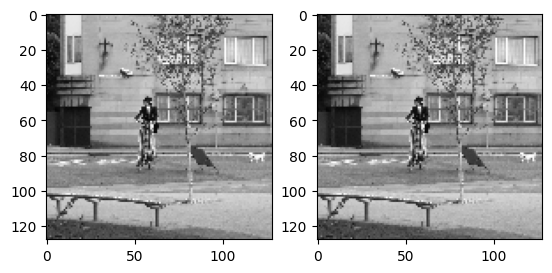

In [3]:
import os
import json
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Define the paths
images_path = 'coco/val2017/'
annotations_path = 'coco/annotations/instances_val2017.json'

# Load annotations
with open(annotations_path) as f:
    annotations = json.load(f)

# Create a mapping from image id to file name
id_to_filename = {image['id']: image['file_name'] for image in annotations['images']}

# Create a function to preprocess images and masks
def preprocess_image_and_mask(image_id, target_size=(128, 128)):
    # Load the image
    img_path = os.path.join(images_path, id_to_filename[image_id])
    img = load_img(img_path, target_size=target_size)
    img = img_to_array(img) / 255.0

    # Create the mask
    mask = np.zeros(target_size + (1,))
    for ann in annotations['annotations']:
        if ann['image_id'] == image_id:
            mask_path = os.path.join(images_path, id_to_filename[image_id])
            mask_img = load_img(mask_path, target_size=target_size, color_mode='grayscale')
            mask += img_to_array(mask_img) / 255.0

    return img, mask

# Test the function
image_id = annotations['annotations'][0]['image_id']
img, mask = preprocess_image_and_mask(image_id)
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.imshow(mask.squeeze(), cmap='gray')
plt.show()


In [4]:
def unet_model(input_size=(128, 128, 3)):
    inputs = layers.Input(input_size)


    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)


    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = models.Model(inputs=[inputs], outputs=[outputs])

    return model

model = unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 64)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 32, 32, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 16, 16, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 16, 16, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 16, 16, 512)    │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 8, 8, 512)      │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 8, 8, 1024)     │      4,719,616 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 8, 8, 1024)     │      9,438,208 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 16, 16, 512)    │      2,097,664 │ conv2d_9[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 16, 16, 1024)   │              0 │ conv2d_transpose[0][0… │
│                      

 Total params: 31,031,745 (118.38 MB)

 Trainable params: 31,031,745 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_val, y_val))


NameError: name 'X_train' is not defined

In [8]:
from sklearn.model_selection import train_test_split

# Function to load and preprocess data
def load_data(image_ids, target_size=(128, 128)):
    images = []
    masks = []
    for image_id in image_ids:
        img, mask = preprocess_image_and_mask(image_id, target_size)
        images.append(img)
        masks.append(mask)
    return np.array(images), np.array(masks)

# Splitting the dataset
image_ids = list(id_to_filename.keys())
train_ids, val_ids = train_test_split(image_ids, test_size=0.2, random_state=42)

# Load training and validation data
X_train, y_train = load_data(train_ids)
X_val, y_val = load_data(val_ids)

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))

# Shuffle and batch the datasets
BATCH_SIZE = 16
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(BATCH_SIZE).repeat()
val_dataset = val_dataset.batch(BATCH_SIZE)


In [ ]:
# Define training parameters
EPOCHS = 10
STEPS_PER_EPOCH = len(train_ids) // BATCH_SIZE
VALIDATION_STEPS = len(val_ids) // BATCH_SIZE

# Training the model
history = model.fit(train_dataset,
                    epochs=EPOCHS,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=val_dataset,
                    validation_steps=VALIDATION_STEPS)


Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 6770s 27s/step - accuracy: 0.0136 - loss: nan - val_accuracy: 0.0162 - val_loss: nan
Epoch 2/10
 11/250 ━━━━━━━━━━━━━━━━━━━━ 1:40:52 25s/step - accuracy: 0.0382 - loss: nan

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(val_dataset, steps=VALIDATION_STEPS)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")

# Visualize predictions
def visualize_predictions(model, dataset, num_images=5):
    for images, masks in dataset.take(num_images):
        predictions = model.predict(images)

        for i in range(len(images)):
            plt.figure(figsize=(15, 5))

            plt.subplot(1, 3, 1)
            plt.imshow(images[i])
            plt.title('Input Image')

            plt.subplot(1, 3, 2)
            plt.imshow(masks[i].squeeze(), cmap='gray')
            plt.title('True Mask')

            plt.subplot(1, 3, 3)
            plt.imshow(predictions[i].squeeze(), cmap='gray')
            plt.title('Predicted Mask')

            plt.show()

# Visualize predictions
visualize_predictions(model, val_dataset)
